In [1]:
import torch 
from torch import nn
from torch.utils import data # 获取迭代数据
from torch.autograd import Variable # 获取变量
import torchvision
from torchvision.datasets import mnist # 获取数据集

from torch.utils.data import random_split
import torch.utils.data as data
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler,WeightedRandomSampler
from torch.utils.data import random_split
from torch.utils.data import SequentialSampler
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import matplotlib.pyplot as plt
import os
pwd = os.getcwd()
#print(pwd)

import os
import sys

# 直接指定项目根目录
project_root = "C:/Users/Admin/Mouse"  # 替换成你的项目根目录路径
datautils_path = os.path.join(project_root, 'datautils')
model_path = os.path.join(project_root, 'model')

# 添加路径
sys.path.extend([datautils_path, model_path])

# 导入模块
from data_utils import load_mouse_data, process_mouse_data

# 然后再导入其他模块
from resnet_mouse import _ResNetLayer
from mouse_traj_classification import MouseNeuralNetwork, MouseNeuralNetwork2
from new_optim import SWATS

In [2]:
import random
random_seed = 3407
# set the random seed for pytorch
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# set the random seed for "random"
random.seed(random_seed)

# set the random seed for numpy
np.random.seed(random_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 设置用户ID和窗口大小
user_id = 23
window_size = 300


# 加载和处理数据
X, label = process_mouse_data(
    f'D:/论文数据/mouse/data/processed_data_user{user_id}/positive_samples_user{user_id}_{window_size}.json',
    f'D:/论文数据/mouse/data/processed_data_user{user_id}/negative_samples_user{user_id}_{window_size}.json'
)
# 计算数据集划分长度
train_len = math.floor(len(X)*0.7)
val_len = math.floor(len(X)*0.2)
test_len = len(X)-train_len-val_len

In [4]:
# 1. 首先检查数据集大小和batch_size的设置
print("数据集总大小:", len(X))
print("训练集大小:", train_len)
print("验证集大小:", val_len)
print("测试集大小:", test_len)

数据集总大小: 715
训练集大小: 500
验证集大小: 143
测试集大小: 72


In [5]:
# 修改数据加载器的创建部分
dataset = torch.utils.data.TensorDataset(
    X.float(),  # 确保输入数据是float类型
    label.long()  # 确保标签是long类型
)
# 统计正负样本数量
pos_indices = (label == 0)  # 正样本索引
neg_indices = (label == 1)  # 负样本索引
pos_data = X[pos_indices]
neg_data = X[neg_indices]
pos_labels = label[pos_indices]
neg_labels = label[neg_indices]

print(f"\nOriginal distribution:")
print(f"Positive samples: {len(pos_data)}")
print(f"Negative samples: {len(neg_data)}")
# 计算每个集合中正负样本的数量
n_pos = len(pos_data)
n_neg = len(neg_data)
train_pos_len = math.floor(n_pos * 0.7)
val_pos_len = math.floor(n_pos * 0.2)
test_pos_len = n_pos - train_pos_len - val_pos_len

train_neg_len = math.floor(n_neg * 0.7)
val_neg_len = math.floor(n_neg * 0.2)
test_neg_len = n_neg - train_neg_len - val_neg_len
# 随机打乱正负样本
pos_indices = torch.randperm(n_pos)
neg_indices = torch.randperm(n_neg)

# 划分正样本
train_pos = pos_data[pos_indices[:train_pos_len]]
val_pos = pos_data[pos_indices[train_pos_len:train_pos_len+val_pos_len]]
test_pos = pos_data[pos_indices[train_pos_len+val_pos_len:]]

train_pos_labels = pos_labels[pos_indices[:train_pos_len]]
val_pos_labels = pos_labels[pos_indices[train_pos_len:train_pos_len+val_pos_len]]
test_pos_labels = pos_labels[pos_indices[train_pos_len+val_pos_len:]]

# 划分负样本
train_neg = neg_data[neg_indices[:train_neg_len]]
val_neg = neg_data[neg_indices[train_neg_len:train_neg_len+val_neg_len]]
test_neg = neg_data[neg_indices[train_neg_len+val_neg_len:]]

train_neg_labels = neg_labels[neg_indices[:train_neg_len]]
val_neg_labels = neg_labels[neg_indices[train_neg_len:train_neg_len+val_neg_len]]
test_neg_labels = neg_labels[neg_indices[train_neg_len+val_neg_len:]]

# 合并正负样本
train_data = torch.cat([train_pos, train_neg])
val_data = torch.cat([val_pos, val_neg])
test_data = torch.cat([test_pos, test_neg])

train_labels = torch.cat([train_pos_labels, train_neg_labels])
val_labels = torch.cat([val_pos_labels, val_neg_labels])
test_labels = torch.cat([test_pos_labels, test_neg_labels])

# 随机打乱每个数据集
train_indices = torch.randperm(len(train_data))
val_indices = torch.randperm(len(val_data))
test_indices = torch.randperm(len(test_data))

train_data = train_data[train_indices]
val_data = val_data[val_indices]
test_data = test_data[test_indices]

train_labels = train_labels[train_indices]
val_labels = val_labels[val_indices]
test_labels = test_labels[test_indices]

# 创建数据集
train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
val_dataset = torch.utils.data.TensorDataset(val_data, val_labels)
test_dataset = torch.utils.data.TensorDataset(test_data, test_labels)
# 打印分布信息
print("\nDistribution after split:")
print("Training set:")
print(f"Positive: {(train_labels == 0).sum().item()}, Negative: {(train_labels == 1).sum().item()}")
print("Validation set:")
print(f"Positive: {(val_labels == 0).sum().item()}, Negative: {(val_labels == 1).sum().item()}")
print("Test set:")
print(f"Positive: {(test_labels == 0).sum().item()}, Negative: {(test_labels == 1).sum().item()}")



Original distribution:
Positive samples: 652
Negative samples: 63

Distribution after split:
Training set:
Positive: 456, Negative: 44
Validation set:
Positive: 130, Negative: 12
Test set:
Positive: 66, Negative: 7


In [6]:
# 计算类别权重
class_count = [len(label[label == t]) for t in torch.unique(label)]
weights = [2.0 if t == 1 else 1.0 for t in label.cpu().numpy()]  # 转换为numpy数组
sample_weights = torch.FloatTensor(weights)
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))


# 设置合适的batch_size
train_batch_size = 64  # 较小的batch_size，可以更好地训练
val_batch_size = 64   # 验证集可以用大一点的batch_size
test_batch_size = 64  # 测试集也可以用大一点的batch_size

# 创建数据加载器
X_train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=64,
    shuffle=True,
    drop_last=False,
    pin_memory=True
)

X_val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=64,
    shuffle=False,
    drop_last=False,
    pin_memory=True
)

X_test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=64,
    shuffle=False,
    drop_last=False,
    pin_memory=True
)

In [7]:
X.shape

torch.Size([715, 11, 300])

In [8]:
# 保存各个数据加载器
# 创建目录
import pickle
base_path = f'D:/论文数据/mouse/data_pkl/processed_data_user{user_id}'
if not os.path.exists(base_path):
    os.makedirs(base_path)
    print(f"Created directory: {base_path}")
else:
    print(f"Directory already exists: {base_path}")
train_path = f'{base_path}/train_loader_user{user_id}_{window_size}.pkl'
val_path = f'{base_path}/val_loader_user{user_id}_{window_size}.pkl'
test_path = f'{base_path}/test_loader_user{user_id}_{window_size}.pkl'

with open(train_path, 'wb') as f:
    pickle.dump(X_train_loader, f)
with open(val_path, 'wb') as f:
    pickle.dump(X_val_loader, f)
with open(test_path, 'wb') as f:
    pickle.dump(X_test_loader, f)

print(f"Train loader saved to: {train_path}")
print(f"Val loader saved to: {val_path}")
print(f"Test loader saved to: {test_path}")

Directory already exists: D:/论文数据/mouse/data_pkl/processed_data_user23
Train loader saved to: D:/论文数据/mouse/data_pkl/processed_data_user23/train_loader_user23_300.pkl
Val loader saved to: D:/论文数据/mouse/data_pkl/processed_data_user23/val_loader_user23_300.pkl
Test loader saved to: D:/论文数据/mouse/data_pkl/processed_data_user23/test_loader_user23_300.pkl


In [9]:
# 读取数据加载器的代码：
with open(train_path, 'rb') as f:
    X_train_loader = pickle.load(f)
with open(val_path, 'rb') as f:
    X_val_loader = pickle.load(f)
with open(test_path, 'rb') as f:
    X_test_loader = pickle.load(f)

print(f"Loaded train loader from: {train_path}")
print(f"Loaded val loader from: {val_path}")
print(f"Loaded test loader from: {test_path}")

Loaded train loader from: D:/论文数据/mouse/data_pkl/processed_data_user23/train_loader_user23_300.pkl
Loaded val loader from: D:/论文数据/mouse/data_pkl/processed_data_user23/val_loader_user23_300.pkl
Loaded test loader from: D:/论文数据/mouse/data_pkl/processed_data_user23/test_loader_user23_300.pkl


In [10]:
# 首先从数据中获取序列长度和特征数量
sequence_length = X.shape[2]  # 序列长度
num_features = X.shape[1]     # 特征数量

# 修改模型初始化部分
model = MouseNeuralNetwork2(length_single_mouse_traj=50)
model = model.to(device)  # 将模型移动到指定设备

# 3. 初始化优化器 (在模型移动到GPU之后初始化优化器)
optimizer = SWATS(model.parameters(), lr=1e-3)
optim_SGD = torch.optim.SGD(
    model.parameters(), 
    lr=1e-4, 
    momentum=0.80, 
    dampening=0, 
    weight_decay=1e-3, 
    nesterov=False
)
optim_ADAM = torch.optim.Adam(
    model.parameters(), 
    lr=1e-3, 
    betas=(0.9, 0.999), 
    eps=1e-08, 
    weight_decay=1e-2
)

# 检查第一个batch的数据
for batch_data, batch_labels in X_train_loader:
    print("数据维度:", batch_data.shape)
    print("标签维度:", batch_labels.shape)
    print("数据类型:", batch_data.dtype)
    print("标签类型:", batch_labels.dtype)
    break

数据维度: torch.Size([64, 11, 300])
标签维度: torch.Size([64])
数据类型: torch.float32
标签类型: torch.float32


In [11]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

def train_ADAM(model, X_train_loader, X_val_loader=None, optimizer=None, epoch=300):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_function = nn.CrossEntropyLoss()
    model = model.to(device)
    loss_function = loss_function.to(device)
    
    losslist = []
    correctlist = []
    val_correctlist = []
    train_correctlist = []
    
    writer = SummaryWriter('/root/tf-logs')
    
    # 使用tqdm创建总进度条
    pbar = tqdm(total=epoch, desc='Training Progress')
    
    for i in range(epoch):
        model.train()
        totalloss = 0
        correct = 0
        total = 0
        num_batches = 0
        
        for data in X_train_loader:
            X, label = data
            X = X.float().to(device)
            label = label.long().to(device)
            
            optimizer.zero_grad()
            pred = model(X).squeeze()
            loss = loss_function(pred, label)
           
            totalloss += loss.item()
            num_batches += 1
            _, pred_id = torch.max(pred, dim=1)
            correct += (pred_id == label).sum().cpu().detach().numpy()
            total += label.size(0)
            
            loss.backward()
            optimizer.step()
        
        train_acc = correct / total
        avg_loss = totalloss / num_batches
        losslist.append(avg_loss)
        
        # 每50个epoch更新一次进度条
        if (i + 1) % 50 == 0:
            pbar.update(50)  # 更新50个步长
            print(f'\nEpoch {i+1}/{epoch} - Loss: {avg_loss:.4f}, Accuracy: {train_acc:.4f}')
            
            if X_val_loader is not None:
                model.eval()
                val_correct = 0
                val_total = 0
                
                with torch.no_grad():
                    for X, label in X_val_loader:
                        X = X.float().to(device)
                        label = label.long().to(device)
                        pred = model(X).squeeze()
                        _, pred_id = torch.max(pred, dim=1)
                        
                        val_correct += (pred_id == label).sum().cpu().detach().numpy()
                        val_total += label.size(0)
                
                val_acc = val_correct / val_total
                print(f'Validation Accuracy: {val_acc:.4f}')
                print('-' * 50)
                
                correctlist.append(val_acc)
                val_correctlist.append(val_acc)
                train_correctlist.append(train_acc)
                
                writer.add_scalar('Training loss', avg_loss, i)
                writer.add_scalar('Training accuracy', train_acc, i)
                writer.add_scalar('Validation accuracy', val_acc, i)
        else:
            # 更新进度条信息但不打印
            pbar.set_postfix({
                'loss': f'{avg_loss:.4f}',
                'acc': f'{train_acc:.4f}'
            })
    
    pbar.close()
    writer.close()
    return optim_ADAM, epoch, losslist, correctlist, train_correctlist

In [12]:
model = MouseNeuralNetwork2(length_single_mouse_traj=window_size)
optimizer = SWATS(model.parameters(), lr=1e-3)
optim_ADAM = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)

In [13]:
# 5. 运行训练
optim_ADAM, epoch, losslist, correctlist, train_correctlist = train_ADAM(
    model, 
    X_train_loader, 
    X_val_loader, 
    optimizer=optim_ADAM, 
    epoch=150
)

Training Progress:  33%|████████████▎                        | 50/150 [00:08<00:16,  5.93it/s, loss=0.4010, acc=0.9120]


Epoch 50/150 - Loss: 0.4015, Accuracy: 0.9120
Validation Accuracy: 0.9155
--------------------------------------------------


Training Progress:  67%|████████████████████████            | 100/150 [00:16<00:08,  5.98it/s, loss=0.3385, acc=0.9740]


Epoch 100/150 - Loss: 0.3398, Accuracy: 0.9740
Validation Accuracy: 0.9296
--------------------------------------------------


Training Progress: 100%|████████████████████████████████████| 150/150 [00:24<00:00,  6.01it/s, loss=0.3292, acc=0.9860]


Epoch 150/150 - Loss: 0.3317, Accuracy: 0.9840
Validation Accuracy: 0.9296
--------------------------------------------------


In [14]:
# 保存模型
state = {'model': model.state_dict()}
torch.save(state, f'D:/论文数据/mouse/model_pt/resnet/only-adam-user{user_id}_{window_size}-path.pt')

In [15]:
import torch

model = MouseNeuralNetwork2(X.shape[2])  # 替换为你的模型
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {params:,} trainable parameters")

Model has 5,903,062 trainable parameters


In [16]:
# 加载预训练模型
model_transfer = MouseNeuralNetwork(window_size)  # 创建新模型
model_pretrain = MouseNeuralNetwork2(window_size)  # 创建预训练模型结构

In [17]:
# 加载预训练权重 - 使用weights_only=True提高安全性
pretrain_path = f'D:/论文数据/mouse/model_pt/resnet/only-adam-user{user_id}_{window_size}-path.pt'
checkpoint = torch.load(pretrain_path, weights_only=True)  # 添加weights_only=True
print(f"Loading pretrained model from: {pretrain_path}")
model_pretrain.load_state_dict(checkpoint['model'])

Loading pretrained model from: D:/论文数据/mouse/model_pt/resnet/only-adam-user23_300-path.pt


<All keys matched successfully>

In [18]:
# 迁移预训练层
model_transfer.layer1 = model_pretrain.layer1
model_transfer.layer2 = model_pretrain.layer2
model_transfer.layer3 = model_pretrain.layer3
# model_transfer.layer4 = model_pretrain.layer4  # 根据需要决定是否迁移第4层

In [19]:
# 加载保存的数据加载器
import pickle
base_path = f'D:/论文数据/mouse/data_pkl/processed_data_user{user_id}'

train_path = f'{base_path}/train_loader_user{user_id}_{window_size}.pkl'
val_path = f'{base_path}/val_loader_user{user_id}_{window_size}.pkl'
test_path = f'{base_path}/test_loader_user{user_id}_{window_size}.pkl'
print(f"Loading data loaders for user {user_id}:")
with open(train_path, 'rb') as f:
    X_train_loader = pickle.load(f)
with open(val_path, 'rb') as f:
    X_val_loader = pickle.load(f)
with open(test_path, 'rb') as f:
    X_test_loader = pickle.load(f)


Loading data loaders for user 23:


In [20]:
# 将模型移到GPU
model_transfer = model_transfer.cuda()
print(f"Model moved to: {next(model_transfer.parameters()).device}")

Model moved to: cuda:0


In [21]:
# 初始化优化器
optimizer = SWATS(model_transfer.parameters(), lr=1e-3)
optim_SGD = torch.optim.SGD(model_transfer.parameters(), lr=1e-4, momentum=0.8, dampening=0, weight_decay=1e-3, nesterov=False)
optim_ADAM = torch.optim.Adam(model_transfer.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)


In [22]:
# 训练迁移模型
optim_ADAM, epoch, losslist, correctlist, train_correctlist = train_ADAM(
    model_transfer, 
    X_train_loader, 
    X_val_loader, 
    optimizer=optim_ADAM, 
    epoch=150
)

Training Progress:  33%|████████████▎                        | 50/150 [00:06<00:12,  8.25it/s, loss=0.0123, acc=0.9980]


Epoch 50/150 - Loss: 0.0231, Accuracy: 0.9960
Validation Accuracy: 0.9155
--------------------------------------------------


Training Progress:  67%|████████████████████████            | 100/150 [00:12<00:06,  8.21it/s, loss=0.0151, acc=0.9940]


Epoch 100/150 - Loss: 0.0131, Accuracy: 0.9960
Validation Accuracy: 0.9296
--------------------------------------------------


Training Progress: 100%|████████████████████████████████████| 150/150 [00:18<00:00,  8.19it/s, loss=0.0026, acc=1.0000]


Epoch 150/150 - Loss: 0.0056, Accuracy: 1.0000
Validation Accuracy: 0.9155
--------------------------------------------------


In [23]:
# 保存迁移后的模型
transfer_save_path = f'D:/论文数据/mouse/model_pt/ending_model/gru-transfer-user{user_id}_{window_size}-path.pt'  # 修改为实际路径
state = {
    'model': model_transfer.state_dict(),
    'epoch': epoch
}
torch.save(state, transfer_save_path)
print(f"Transfer model saved to: {transfer_save_path}")

Transfer model saved to: D:/论文数据/mouse/model_pt/ending_model/gru-transfer-user23_300-path.pt


In [24]:
import torch

model = MouseNeuralNetwork(X.shape[2])  # 替换为你的模型
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {params:,} trainable parameters")

Model has 751,801 trainable parameters


In [25]:
# 第一部分: 导入必要的库
import torch 
from torch import nn
from torch.utils import data
from torch.autograd import Variable
import torchvision
from torch.utils.data import random_split
import torch.utils.data as data
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, WeightedRandomSampler
from torch.utils.data import SequentialSampler

import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import random
import json
import dill
import time
import pandas as pd
import os
# 导入所需模块
from resnet_mouse import _ResNetLayer
from mouse_traj_classification import MouseNeuralNetwork, MouseNeuralNetwork2
from torch.optim import Optimizer, SGD, Adam
from data_utils import read_test_data_shape, insert_new_test_data
from testdata_utils import process_predict_data

In [26]:
def save_results_to_csv(user_id, window_size, metrics_dict, csv_path):
    """
    保存结果到CSV文件
    Args:
        user_id: 用户ID
        window_size: 窗口大小
        metrics_dict: 包含各项指标的字典
        csv_path: CSV文件路径
    """
    # 定义列名
    columns = ['user_id', 'window_size', 'recall', 'accuracy', 'precision', 'F1', 'AUC', 'EER']
    
    # 检查文件是否存在
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
    else:
        df = pd.DataFrame(columns=columns)
    
    # 创建新行数据
    new_row = pd.DataFrame([{
        'user_id': f'user{user_id}',
        'window_size': window_size,
        'recall': metrics_dict['recall'],
        'accuracy': metrics_dict['accuracy'],
        'precision': metrics_dict['precision'],
        'F1': metrics_dict['f1'],
        'AUC': metrics_dict['auc'],
        'EER': metrics_dict['eer']
    }])
    
    # 使用concat替代append
    df = pd.concat([df, new_row], ignore_index=True)
    
    # 保存到CSV
    df.to_csv(csv_path, index=False)
    print(f"Results saved to {csv_path}")

In [27]:
# 评估函数
def val(model, data_loader):
    correct = 0 
    fenmu = 0
    New_label = []
    
    total_inference_time = 0
    num_inferences = 0

    for data in data_loader:
        X, label = data
        model.zero_grad()
        
        start_time = time.time()
        pred = model(X).squeeze()
        end_time = time.time()
        
        total_inference_time += (end_time - start_time)
        num_inferences += X.size(0)
        
        _, pred_id = torch.max(pred, dim=1)
        correct += (pred_id == label).sum().cpu().detach().numpy()
        New_label.append(label)
        fenmu += label.size(0)
        
    correct = correct / fenmu
    avg_inference_time = total_inference_time / num_inferences
    print(f"Average inference time: {avg_inference_time:.6f} seconds")
    
    return pred_id, pred, label

def recall(predictions, labels):
    TP, FP, TN, FN = 0, 0, 0, 0
    for i in range(len(predictions)):
        if predictions[i] == 1 and labels[i] == 1:
            TP += 1
        elif predictions[i] == 1 and labels[i] == 0:
            FP += 1
        elif predictions[i] == 0 and labels[i] == 0:
            TN += 1
        elif predictions[i] == 0 and labels[i] == 1:
            FN += 1
    if (TP + FN) == 0:
        print(predictions)
        print(labels)
    recall = TP / (TP + FN)
    return recall

def et_TPFN(predictions, labels):
    TP, FP, TN, FN = 0, 0, 0, 0
    for i in range(len(predictions)):
        if predictions[i] == 1 and labels[i] == 1:
            TP += 1
        elif predictions[i] == 1 and labels[i] == 0:
            FP += 1
        elif predictions[i] == 0 and labels[i] == 0:
            TN += 1
        elif predictions[i] == 0 and labels[i] == 1:
            FN += 1
    return TP, FP, TN, FN

def pre(predictions, labels):
    TP, FP, TN, FN = 0, 0, 0, 0
    for i in range(len(predictions)):
        if predictions[i] == 1 and labels[i] == 1:
            TP += 1
        elif predictions[i] == 1 and labels[i] == 0:
            FP += 1
        elif predictions[i] == 0 and labels[i] == 0:
            TN += 1
        elif predictions[i] == 0 and labels[i] == 1:
            FN += 1
    return TP/(FP+TP)
# 在评估函数部分添加新的指标计算函数
def calculate_f1(precision, recall):
    """计算F1分数"""
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

def calculate_eer(fpr, tpr):
    """计算EER (Equal Error Rate)"""
    fnr = 1 - tpr
    # EER是当FAR(FPR)等于FRR(FNR)时的值
    eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]
    return eer

In [28]:
# 1. 加载原始测试数据
test_path = f'D:/论文数据/mouse/data_pkl/processed_data_user{user_id}/test_loader_user{user_id}_{window_size}.pkl'
print(f"\nLoading test data from: {test_path}")
with open(test_path,'rb') as f:
    X_test_loader = dill.load(f)

# 打印原始测试集尺寸
shape_single_mouse_traj = read_test_data_shape(X_test_loader)
original_size = 0
for data in X_test_loader:
    X, _ = data
    original_size += len(X)
print(f"Original test data shape: {shape_single_mouse_traj}")


Loading test data from: D:/论文数据/mouse/data_pkl/processed_data_user23/test_loader_user23_300.pkl
Original test data shape: torch.Size([64, 11, 300])


In [29]:
# 2. 加载和处理预测数据
predict_path = f'D:/论文数据/mouse/data/processed_data_user{user_id}/predict_samples_user{user_id}_{window_size}.json'
print(f"\nLoading predict data from: {predict_path}")

# 读取预测数据
with open(predict_path, 'r') as f:
    predict_data = json.load(f)

# 转换数据格式
trajectories = []
for sample in predict_data['samples']:
    trajectory = np.array([[step[feature] for feature in predict_data['metadata']['feature_names']] 
                         for step in sample])
    trajectories.append(trajectory)

X_insert = np.array(trajectories)
X_insert = torch.FloatTensor(X_insert).transpose(1, 2)
# 检查原始测试数据的维度
for data in X_test_loader:
    X_test, _ = data
    print(f"Original test data tensor shape: {X_test.shape}")
    if len(X_test.shape) == 4:  # 如果原始数据是4维
        X_insert = X_insert.unsqueeze(dim=1)  # 增加一个维度
    break

print(f"Predict samples shape: {X_insert.shape}")

label_insert = torch.zeros(len(X_insert), dtype=torch.int64)


Loading predict data from: D:/论文数据/mouse/data/processed_data_user23/predict_samples_user23_300.json
Original test data tensor shape: torch.Size([64, 11, 300])
Predict samples shape: torch.Size([64, 11, 300])


In [30]:
# 计算总样本数，用作batch_size
total_samples = original_size + len(X_insert)
print(total_samples)
# 创建新的测试数据加载器
new_test_dataloader = insert_new_test_data(X_test_loader, X_insert, label_insert, total_samples)
shape_new_single_mouse_traj = read_test_data_shape(new_test_dataloader)
print(f"Shape after insertion: {shape_new_single_mouse_traj}")

137
Shape after insertion: torch.Size([137, 11, 300])


In [31]:
# 3. 创建和加载模型
New_model_new_test = MouseNeuralNetwork(shape_new_single_mouse_traj[-1])
model_path = f'D:/论文数据/mouse/model_pt/ending_model/gru-transfer-user{user_id}_{window_size}-path.pt'
print(f"\nLoading model from: {model_path}")
checkpoint = torch.load(model_path, weights_only=True) 
New_model_new_test.load_state_dict(checkpoint['model'])


Loading model from: D:/论文数据/mouse/model_pt/ending_model/gru-transfer-user23_300-path.pt


<All keys matched successfully>

In [32]:
from sklearn import metrics
import numpy as np
# 4. 评估原始测试集
print("\nEvaluating original test set...")
d_c = []      # recall
d_acc = []    # accuracy
d_precsion = [] # precision
d_f1 = []     # F1 score
d_auc = []    # AUC
d_eer = []    # EER

for i in range(10):
    pred_id_list, pred_list, label_list = val(New_model_new_test, X_test_loader)
    # 确保数据格式正确
    if isinstance(pred_list, torch.Tensor):
        pred_probs = pred_list.detach().cpu().numpy()
    else:
        pred_probs = pred_list
        
    if isinstance(label_list, torch.Tensor):
        labels = label_list.cpu().numpy()
    else:
        labels = label_list
    
    # 计算基本指标
    zhaohui = recall(pred_id_list, label_list)
    c = et_TPFN(pred_id_list, label_list)
    acc = (c[0]+c[2])/( c[0]+c[1]+c[2]+c[3])
    precision = pre(pred_id_list, label_list)
    
    # 计算F1分数
    f1 = calculate_f1(precision, zhaohui)
    
    # 计算ROC和AUC
    fpr, tpr, _ = metrics.roc_curve(labels, pred_probs[:, 1])
    auc = metrics.auc(fpr, tpr)
    
    # 计算EER
    eer = calculate_eer(fpr, tpr)
    
    # 保存所有指标
    d_c.append(zhaohui)
    d_acc.append(acc)
    d_precsion.append(precision)
    d_f1.append(f1)
    d_auc.append(auc)
    d_eer.append(eer)
    
    print(f"Round {i+1}/10 completed")

print("\nOriginal Test Set Results:")
print(f"Average Recall: {np.mean(d_c):.4f} ± {np.std(d_c):.4f}")
print(f"Average Accuracy: {np.mean(d_acc):.4f} ± {np.std(d_acc):.4f}")
print(f"Average Precision: {np.mean(d_precsion):.4f} ± {np.std(d_precsion):.4f}")
print(f"Average F1 Score: {np.mean(d_f1):.4f} ± {np.std(d_f1):.4f}")
print(f"Average AUC: {np.mean(d_auc):.4f} ± {np.std(d_auc):.4f}")
print(f"Average EER: {np.mean(d_eer):.4f} ± {np.std(d_eer):.4f}")


# 保存原始测试集结果
original_metrics = {
    'recall': np.mean(d_c),
    'accuracy': np.mean(d_acc),
    'precision': np.mean(d_precsion),
    'f1': np.mean(d_f1),
    'auc': np.mean(d_auc),
    'eer': np.mean(d_eer)
}

# 定义基础路径
base_path = f'D:/论文数据/mouse/RESULTS'

# 确保目录存在
os.makedirs(base_path, exist_ok=True)

# 构建文件名，添加 user_id 和 window_size
filename = f'original_test_results_user{user_id}.csv'

# 拼接完整的文件路径
full_path = os.path.join(base_path, filename)

# 调用保存函数
save_results_to_csv(user_id, window_size, original_metrics, full_path)


Evaluating original test set...
Average inference time: 0.004384 seconds
Round 1/10 completed
Average inference time: 0.003217 seconds
Round 2/10 completed
Average inference time: 0.003375 seconds
Round 3/10 completed
Average inference time: 0.003819 seconds
Round 4/10 completed
Average inference time: 0.003250 seconds
Round 5/10 completed
Average inference time: 0.003200 seconds
Round 6/10 completed
Average inference time: 0.003508 seconds
Round 7/10 completed
Average inference time: 0.003217 seconds
Round 8/10 completed
Average inference time: 0.003249 seconds
Round 9/10 completed
Average inference time: 0.003187 seconds
Round 10/10 completed

Original Test Set Results:
Average Recall: 1.0000 ± 0.0000
Average Accuracy: 1.0000 ± 0.0000
Average Precision: 1.0000 ± 0.0000
Average F1 Score: 1.0000 ± 0.0000
Average AUC: 1.0000 ± 0.0000
Average EER: 0.0000 ± 0.0000
Results saved to D:/论文数据/mouse/RESULTS\original_test_results_user23.csv


In [33]:
# 5. 评估插入预测样本后的测试集
print("\nEvaluating test set with predict samples...")
d_c_2 = []
d_acc_2 = []
d_precsion_2 = []
d_f1_2 = []
d_auc_2 = []    # 添加AUC列表
d_eer_2 = []

for i in range(10):
    pred_id_list, pred_list, label_list = val(New_model_new_test, new_test_dataloader)
    # 确保数据格式正确
    if isinstance(pred_list, torch.Tensor):
        pred_probs = pred_list.detach().cpu().numpy()
    else:
        pred_probs = pred_list
        
    if isinstance(label_list, torch.Tensor):
        labels = label_list.cpu().numpy()
    else:
        labels = label_list
    
    # 计算基本指标
    zhaohui = recall(pred_id_list, label_list)
    c = et_TPFN(pred_id_list, label_list)
    acc = (c[0]+c[2])/( c[0]+c[1]+c[2]+c[3])
    precision = pre(pred_id_list, label_list)
    
    # 计算F1分数
    f1 = calculate_f1(precision, zhaohui)
    
    # 计算ROC和AUC
    fpr, tpr, _ = metrics.roc_curve(labels, pred_probs[:, 1])
    auc = metrics.auc(fpr, tpr)
    
    # 计算EER
    eer = calculate_eer(fpr, tpr)
    
    # 保存所有指标
    d_c_2.append(zhaohui)
    d_acc_2.append(acc)
    d_precsion_2.append(precision)
    d_f1_2.append(f1)
    d_auc_2.append(auc)    # 保存AUC值
    d_eer_2.append(eer)
    
    print(f"Round {i+1}/10 completed")

print("\nTest Set with Predict Samples Results:")
print(f"Average Recall: {np.mean(d_c_2):.4f} ± {np.std(d_c_2):.4f}")
print(f"Average Accuracy: {np.mean(d_acc_2):.4f} ± {np.std(d_acc_2):.4f}")
print(f"Average Precision: {np.mean(d_precsion_2):.4f} ± {np.std(d_precsion_2):.4f}")
print(f"Average F1 Score: {np.mean(d_f1_2):.4f} ± {np.std(d_f1_2):.4f}")
print(f"Average AUC: {np.mean(d_auc_2):.4f} ± {np.std(d_auc_2):.4f}")    # 打印AUC结果
print(f"Average EER: {np.mean(d_eer_2):.4f} ± {np.std(d_eer_2):.4f}")

# 保存插入预测样本后的测试集结果
merged_metrics = {
    'recall': np.mean(d_c_2),
    'accuracy': np.mean(d_acc_2),
    'precision': np.mean(d_precsion_2),
    'f1': np.mean(d_f1_2),
    'auc': np.mean(d_auc_2),    # 添加AUC到保存结果中
    'eer': np.mean(d_eer_2)
}
# 定义基础路径
base_path = f'D:/论文数据/mouse/RESULTS'

# 确保目录存在
os.makedirs(base_path, exist_ok=True)

# 构建文件名，添加 user_id 和 window_size
filename = f'merged_test_results_user{user_id}.csv'

# 拼接完整的文件路径
full_path = os.path.join(base_path, filename)

# 调用保存函数
save_results_to_csv(user_id, window_size, merged_metrics, full_path)



Evaluating test set with predict samples...
Average inference time: 0.002636 seconds
Round 1/10 completed
Average inference time: 0.002953 seconds
Round 2/10 completed
Average inference time: 0.002098 seconds
Round 3/10 completed
Average inference time: 0.002442 seconds
Round 4/10 completed
Average inference time: 0.002510 seconds
Round 5/10 completed
Average inference time: 0.001966 seconds
Round 6/10 completed
Average inference time: 0.003209 seconds
Round 7/10 completed
Average inference time: 0.002068 seconds
Round 8/10 completed
Average inference time: 0.002485 seconds
Round 9/10 completed
Average inference time: 0.002233 seconds
Round 10/10 completed

Test Set with Predict Samples Results:
Average Recall: 0.1429 ± 0.0000
Average Accuracy: 0.8832 ± 0.0146
Average Precision: 0.0941 ± 0.0181
Average F1 Score: 0.1125 ± 0.0127
Average AUC: 0.6874 ± 0.0217
Average EER: 0.4077 ± 0.0371
Results saved to D:/论文数据/mouse/RESULTS\merged_test_results_user23.csv


Average inference time: 0.003322 seconds
Average inference time: 0.002690 seconds


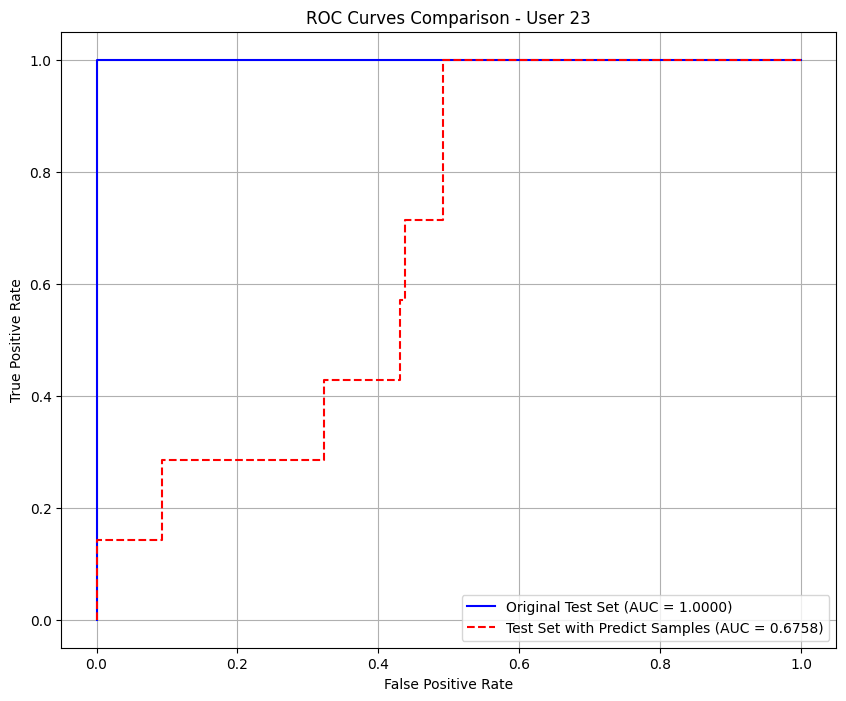

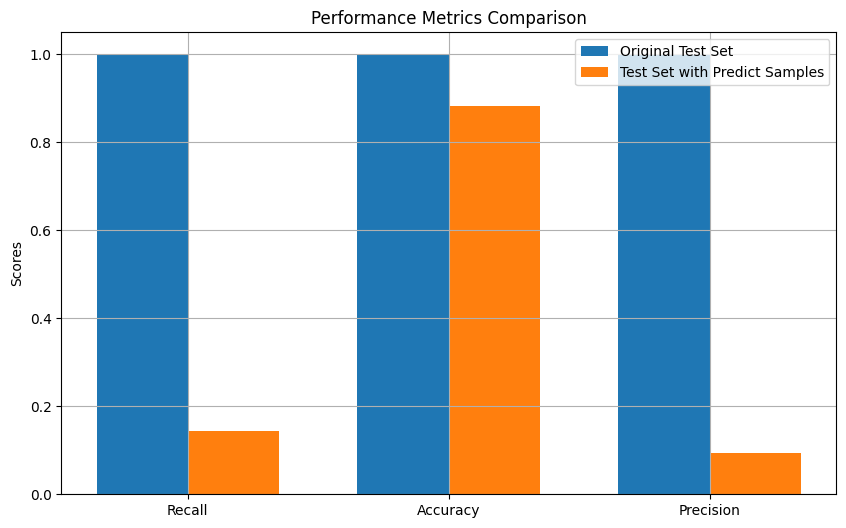

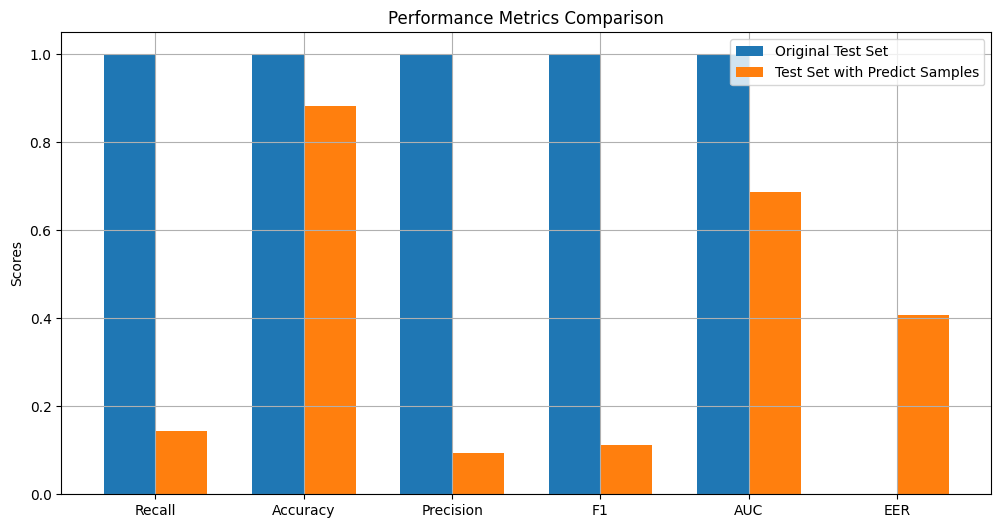

In [34]:
# 6. 计算和绘制ROC曲线
from sklearn import metrics

# 计算第一个测试集的ROC
pred_id, pred, label = val(New_model_new_test, X_test_loader)
fpr1, tpr1, _ = metrics.roc_curve(label, pred[:,1].detach().numpy())
auc1 = metrics.auc(fpr1, tpr1)

# 计算第二个测试集的ROC
pred_id2, pred2, label2 = val(New_model_new_test, new_test_dataloader)
fpr2, tpr2, _ = metrics.roc_curve(label2, pred2[:,1].detach().numpy())
auc2 = metrics.auc(fpr2, tpr2)

# 绘制ROC曲线对比图
plt.figure(figsize=(10,8))
plt.plot(fpr1, tpr1, 'b-', label=f'Original Test Set (AUC = {auc1:.4f})')
plt.plot(fpr2, tpr2, 'r--', label=f'Test Set with Predict Samples (AUC = {auc2:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves Comparison - User {user_id}')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 7. 绘制性能指标对比图
metrics = ['Recall', 'Accuracy', 'Precision']
test1_scores = [np.mean(d_c), np.mean(d_acc), np.mean(d_precsion)]
test2_scores = [np.mean(d_c_2), np.mean(d_acc_2), np.mean(d_precsion_2)]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, test1_scores, width, label='Original Test Set')
plt.bar(x + width/2, test2_scores, width, label='Test Set with Predict Samples')

plt.ylabel('Scores')
plt.title('Performance Metrics Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True)
plt.show()


# 更新性能指标对比图，包含AUC
metrics = ['Recall', 'Accuracy', 'Precision', 'F1', 'AUC', 'EER']
test1_scores = [np.mean(d_c), np.mean(d_acc), np.mean(d_precsion), 
                np.mean(d_f1), np.mean(d_auc), np.mean(d_eer)]
test2_scores = [np.mean(d_c_2), np.mean(d_acc_2), np.mean(d_precsion_2), 
                np.mean(d_f1_2), np.mean(d_auc_2), np.mean(d_eer_2)]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(12,6))
plt.bar(x - width/2, test1_scores, width, label='Original Test Set')
plt.bar(x + width/2, test2_scores, width, label='Test Set with Predict Samples')

plt.ylabel('Scores')
plt.title('Performance Metrics Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True)
plt.show()